In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from modules import preprocess
from IPython.display import Image

number_to_month = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "june", 7: "july", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"} 
us_wheat_state_selector = ['08', '20', '31', '40', '46', '48'] 
br_wheat_state_selector = ['Paraná', 'Santa Catarina', 'Rio Grande do Sul']
id_vars=["adm_id", "number", "year", "init_date", "init_time_step"]
relevant_columns = ['tavg', 'prec', 'tmax', 'tmin']

day_of_year_to_time_step = {
    1: 0, 9: 1, 17: 2, 25: 3, 33: 4, 41: 5, 49: 6, 57: 7, 65: 8, 73: 9, 81: 10, 89: 11, 
    97: 12, 105: 13, 113: 14, 121: 15, 129: 16, 137: 17, 145: 18, 153: 19, 161: 20, 
    169: 21, 177: 22, 185: 23, 193: 24, 201: 25, 209: 26
}

%load_ext autoreload
%autoreload 2

### 1. Set study metadata

In [2]:
# USER INPUTS
ecmwf_country = "US" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]
init_month = "july" # one of ["jan", "feb", "mar", "apr", "may", "june", "july"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, offset, test_years = preprocess.get_study_metadata(ecmwf_country, crop)
print(shapefile_path, crop, ecmwf_country, crop_season_in_days_of_year, crop_season_in_months, offset, test_years)

../data/shapefiles/US/tl_2023_us_county.shp wheat US (1, 209) (1, 7) 19 [2021, 2022, 2023]


### 2. Read 16-day ERA features

Here, in this notebook, ERA data is needed for bias adjustment. The ERA features are preprocessed and exported with the other CY-Bench data in the notebook *3_feature_preprocessing.ipynb*.

In [3]:
era = pd.read_csv("../data/preprocessed/{}/cy_bench_16daybins_{}_{}_v8.csv".format(ecmwf_country, crop, ecmwf_country))
era = era.loc[:, ["adm_id", "harvest_year"] + [c for c in era.columns if ("tavg" in c) or ("prec" in c) or ("tmax" in c) or ("tmin" in c)]]
era = era.rename(columns={"harvest_year": "year"})

relevant_adm_ids = era["adm_id"].unique()

merged_df = preprocess.transform_to_time_step(relevant_columns[0], era)
for col in relevant_columns[1:]:
    merged_df = merged_df.merge(preprocess.transform_to_time_step(col, era), on=['adm_id', 'year', 'time_step'], how='inner')
era = merged_df
era.head(2)

,adm_id,year,time_step,tavg,prec,tmax,tmin
0,US-08-001,2007,1,22.609510,1.953361,29.442339,17.179919
1,US-08-001,2008,1,24.293954,0.769508,31.544041,18.023152


### 3. Read and filter shapefiles and visualize study region

<Axes: >

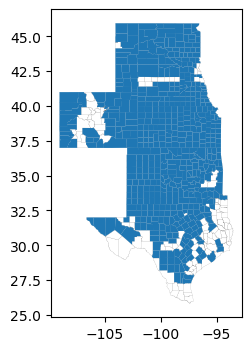

In [4]:
country_gpd = gpd.read_file(shapefile_path)

country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd = country_gpd.loc[country_gpd["STATEFP"].isin(us_wheat_state_selector)].reset_index(drop=True)
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd = country_gpd.loc[country_gpd["ADM1_PT"].isin(br_wheat_state_selector)].reset_index(drop=True)
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]

country_gpd_crop = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids), ["STATEFP", 'geometry', 'adm_id']].reset_index(drop=True)
country_gpd_shape = country_gpd_crop.dissolve().to_crs("EPSG:4326")
distance_df = preprocess.calculate_pairwise_distances(country_gpd_crop)

base = country_gpd.plot(color="white", edgecolor="black", linewidth=.05, figsize=(4, 4))
country_gpd_crop.plot(ax=base)

### 4. Read ECMWF

Seasonal climate models (SCM) from ECMWF are initialized at the first of each month from January to December. The forecasts are provided for 7 months ahead. In-season yield forecasts will be validated throughout the season each time a new ECMWF forecasts is available at the beginning of each month. Below is an illustration of how ERA and SCM data will be concatenated depending on the month of initialization. Furthermore, since forecast length is up to 7 month, in-season yield forecast validation will start earliest 7 month before harvest. All past months will be consecutively supplemented wit AgERA5 data from CY-Bench each month as harvest is approached. See example wheat cropping season in Brazil from May to November (green dashed line) and in the US (blue dashed line) in the image below.

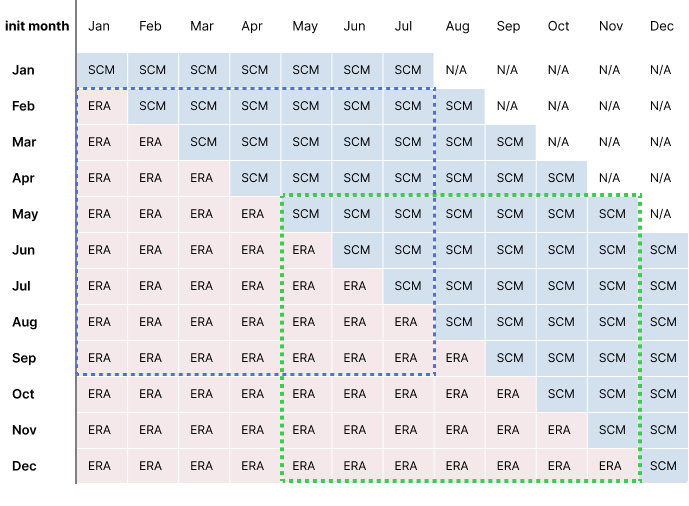

In [5]:
Image(filename="figures/era_scm_us_br_overview.png", width=550)

In [10]:
# Takes roughly 5 minutes to run for July (US, wheat), more for other months further away from harvest
li = []
for ensemble_member in range(0, 25):
    print(ensemble_member)
    ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/{}/ecmwf_{}_{}.csv".format(ecmwf_country, init_month, init_month, ensemble_member))
    ecmwf = preprocess.format_ecmwf_columns(ecmwf)
    if init_month == "may":
        ecmwf = ecmwf.assign(valid_time=ecmwf["valid_time"]- pd.Timedelta(days=1), init_date=ecmwf["init_date"] - pd.Timedelta(days=1))
        ecmwf["doy"] = ecmwf["valid_time"].dt.day_of_year
    ecmwf_resampled = preprocess.resample_ecmwf(ecmwf, crop_season_in_days_of_year)
    ecmwf_assigned = preprocess.assign_ecmwf_forecasts_to_adm_units(ecmwf_resampled, country_gpd_crop)
    if init_month == "may":
        ecmwf_assigned["init_date"] = ecmwf_assigned["init_date"] + pd.Timedelta(days=1)
    # This is needed to make sure that there is an even number of 8 day time steps 
    # to be aggregated and aligned with the 16 day time steps from cy-bench.
    init_time_step = ecmwf_assigned["time_step"].min()
    if ((45 - init_time_step) % 2) == 1:
        ecmwf_assigned = ecmwf_assigned.loc[ecmwf_assigned["time_step"] > init_time_step].reset_index(drop=True)
    
    ecmwf_pivot = preprocess.pivot_ecmwf(ecmwf_assigned)
    ecmwf_16day= preprocess.temporal_aggregation_ecmwf(ecmwf_pivot, relevant_columns, id_vars, 2)
    li.append(ecmwf_16day)
ecmwf = pd.concat(li)
ecmwf = ecmwf.loc[ecmwf["adm_id"].isin(relevant_adm_ids), :].reset_index(drop=True)

ecmwf.head(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


,adm_id,number,year,init_date,init_time_step,tavg_43,tavg_45,prec_43,prec_45,tmax_43,tmax_45,tmin_43,tmin_45
0,US-08-001,0,2004,2004-07-01,42,27.775155,33.797495,2.254367,1.087888,30.831446,36.552911,15.618557,20.740442
1,US-08-001,0,2005,2005-07-01,42,29.471094,27.846339,2.236929,3.631182,33.055919,31.306864,18.126078,17.893474


### 5. Bias Adjustment

From this notebook we will export two dataframes:

- ecmwf without bias adjustment, which was created in the previous cell
- ecmwf with bias adjustment, which we will create now

For the bias adjustment we need to melt the pivoted ecmwf dataframe again as the melted structure allows for faster bias adjustment 

In [11]:
merged_df = preprocess.transform_to_time_step(relevant_columns[0], ecmwf, id_vars=id_vars)
for col in relevant_columns[1:]:
    merged_df = merged_df.merge(preprocess.transform_to_time_step(col, ecmwf, id_vars=id_vars), on=id_vars + ["time_step"], how='inner')
ecmwf_ba = merged_df

era = era.loc[era["time_step"].isin(ecmwf_ba["time_step"].unique()), :].reset_index(drop=True)

Bias adjustment in seasonal climate models addresses systematic errors between simulated climate statistics and corresponding real-world observations over historical periods. These biases can arise from various factors, including inaccurately resolved topography, misrepresentation of processes like convection, or misplacement of large-scale phenomena such as midlatitude circulation. 

**Quantile mapping** has become one of the most widely accepted approaches for bias correction in climate models. This method addresses biases by adjusting the distribution of modeled data to match the distribution of observed data. The image below is from [Maraun (2018)](https://link.springer.com/article/10.1007/s40641-016-0050-x) and illustrates how quantile mapping works.

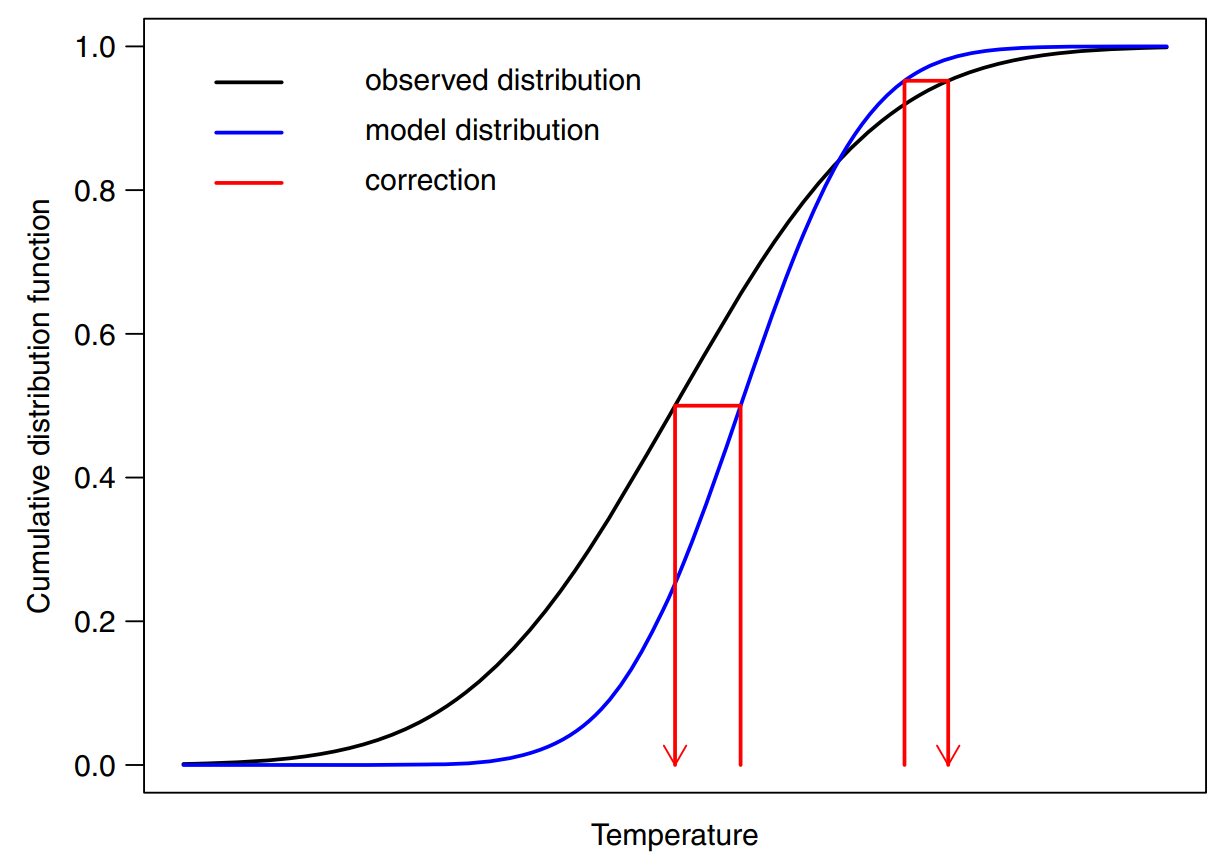

In [12]:
Image(filename="figures/bias_adjustment_quantile_mapping.png", width=400)

The reference periods to build the CDFs for both simulated and observed data is from 2004 to 2017 to be aligned with our training period.

Bias are adjusted per year, time_step and adm_id. The SCM reference period contains data from all 25 ensemble members, such that the distribution and CDF can be reliably esitmated. The ERA reference period would only contain 14 data points in this case (14 years) which is very little to reliably estimate the distribution and the CDF. To improve CDF estimation, we take data not only from the current adm_id but also from its 2 nearest neighbours.

In [13]:
ecmwf_ba.head(1)

,adm_id,number,year,init_date,init_time_step,time_step,tavg,prec,tmax,tmin
0,US-08-001,0,2004,2004-07-01,42,43,27.775155,2.254367,30.831446,15.618557


In [14]:
li = []
counter = 0
ecmwf_unmodified = ecmwf_ba.loc[ecmwf_ba["init_date"].dt.year.between(2004, 2017)].reset_index(drop=True).copy()
groupby_object = ecmwf_ba.groupby(["adm_id", "time_step"])
number_of_groups = len(groupby_object)
print(number_of_groups)
for name, group in groupby_object:
    counter += 1
    print(100 * np.round(counter / number_of_groups, 4))
    # get the ecmwf data that is needed to calculate the cumulative density function
    ecmwf_cdf = ecmwf_unmodified.loc[(ecmwf_unmodified["adm_id"] == group["adm_id"].unique()[0]) & (ecmwf_unmodified["time_step"] == group["time_step"].unique()[0])].reset_index(drop=True)
    # get the era data that is needed to calculate the cumulative density function
    era_cdf = preprocess.get_era_for_n_nearest_neighbors(era, group["adm_id"].unique()[0], 3, distance_df)
    era_cdf = era_cdf.loc[(era_cdf["year"].between(2004, 2017)) & (era_cdf["time_step"] == group["time_step"].unique()[0])].reset_index(drop=True)
     
    for col in ["tavg", "tmax", "tmin", "prec"]:
        result = preprocess.normal_correction(era_cdf[col], ecmwf_cdf[col], group[col])
        group[col] = result
    li.append(group)
    
ecmwf_ba = pd.concat(li)
ecmwf_ba.loc[ecmwf_ba["prec"] < 0, "prec"] = 0
ecmwf_ba = preprocess.pivot_ecmwf(ecmwf_ba, adjust_time_step=False)
ecmwf_ba = ecmwf_ba.assign(init_time_step=ecmwf["init_time_step"].unique()[0])


1080
0.09
0.19
0.27999999999999997
0.37
0.45999999999999996
0.5599999999999999
0.65
0.74
0.83
0.9299999999999999
1.02
1.11
1.2
1.3
1.39
1.48
1.5699999999999998
1.67
1.76
1.8499999999999999
1.94
2.04
2.13
2.22
2.31
2.41
2.5
2.59
2.69
2.78
2.87
2.96
3.06
3.15
3.2399999999999998
3.3300000000000005
3.4299999999999997
3.52
3.61
3.6999999999999997
3.8
3.8899999999999997
3.9800000000000004
4.07
4.17
4.26
4.35
4.44
4.54
4.63
4.72
4.81
4.91
5.0
5.09
5.19
5.28
5.37
5.46
5.56
5.65
5.74
5.83
5.93
6.02
6.11
6.2
6.3
6.39
6.4799999999999995
6.569999999999999
6.67
6.76
6.8500000000000005
6.94
7.04
7.13
7.22
7.31
7.41
7.5
7.59
7.6899999999999995
7.779999999999999
7.870000000000001
7.960000000000001
8.06
8.15
8.24
8.33
8.43
8.52
8.61
8.7
8.799999999999999
8.89
8.98
9.07
9.17
9.26
9.35
9.44
9.54
9.629999999999999
9.719999999999999
9.81
9.91
10.0
10.09
10.190000000000001
10.280000000000001
10.37
10.459999999999999
10.56
10.65
10.74
10.83
10.93
11.020000000000001
11.110000000000001
11.200000000000001
11.3


In [15]:
ecmwf_ba.head()

,adm_id,number,init_date,init_time_step,year,tavg_43,tavg_45,tmin_43,tmin_45,tmax_43,tmax_45,prec_43,prec_45
0,US-08-001,0,2004-07-01,42,2004,22.398554,26.158797,15.259285,19.459201,29.345100,33.885074,1.998344,0.722166
1,US-08-001,0,2005-07-01,42,2005,23.201967,22.048947,16.900068,16.686469,30.601183,28.943324,1.982526,2.661313
2,US-08-001,0,2006-07-01,42,2006,22.813933,23.651851,16.377878,17.077520,29.876627,30.950139,2.204942,1.293524
3,US-08-001,0,2007-07-01,42,2007,24.690085,24.186702,17.919844,18.290151,31.632556,31.325851,0.367842,0.584402
4,US-08-001,0,2008-07-01,42,2008,22.822333,23.785249,16.726037,17.207728,30.371865,30.486311,1.823119,1.497395


# EXPORT

In [16]:
ecmwf.dropna().to_csv("../data/preprocessed/{}/ecmwf_{}_{}_no_ba_{}_16daybins.csv".format(ecmwf_country, crop, ecmwf_country, init_month), index=False)
ecmwf_ba.dropna().to_csv("../data/preprocessed/{}/ecmwf_{}_{}_ba_{}_16daybins.csv".format(ecmwf_country, crop, ecmwf_country, init_month), index=False)